<a href="https://colab.research.google.com/github/eyvonne/DS-Unit-2-Regression-Classification/blob/master/module3/Eyve_Geo_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)



In [4]:
df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'])
train=df[df['SALE_DATE']<'2019-04']
test=df[df['SALE_DATE']>='2019-04']
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [0]:
#remove entries that don't match the requirements for the assignment
mask = (
    (df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS') &
    (df['SALE_PRICE']>100000) &
    (df['SALE_PRICE']<2000000))
df= df[mask]
#Apartment number and Ease-ment are both all na and are therefore dropped 
df=df.drop(labels=['APARTMENT_NUMBER','EASE-MENT'], axis=1)
#extra cleanup I found while doing graphs
df=df[df['TOTAL_UNITS']==1]
df['LAND_SQUARE_FEET']=df['LAND_SQUARE_FEET'].str.replace(',','').astype(int)

In [0]:
#do the train test split
train=df[df['SALE_DATE']<'2019-04']
test=df[df['SALE_DATE']>='2019-04']

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


In [120]:
df.dtypes

TypeError: ignored

BOROUGH


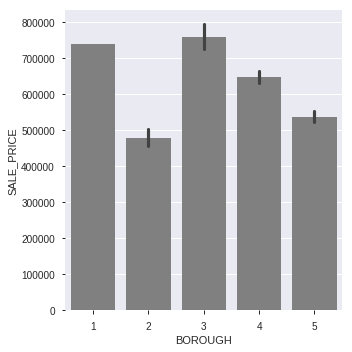

BLOCK 2019 int64
LOT 303 int64
ZIP_CODE 121 float64
LAND_SQUARE_FEET 870 int64
GROSS_SQUARE_FEET 904 float64
YEAR_BUILT 84 float64
SALE_PRICE 859 int64
BUILDING_CLASS_AT_TIME_OF_SALE_A9


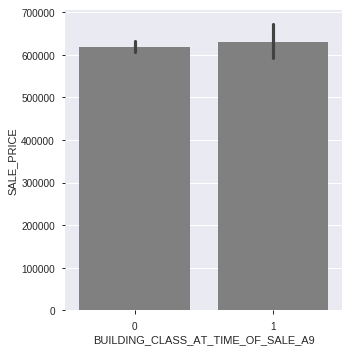

BUILDING_CLASS_AT_TIME_OF_SALE_A1


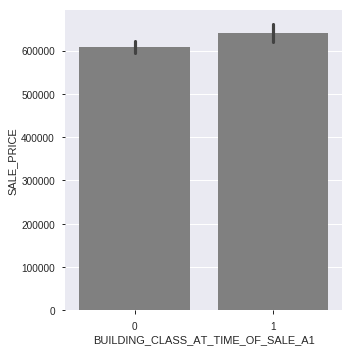

BUILDING_CLASS_AT_TIME_OF_SALE_A5


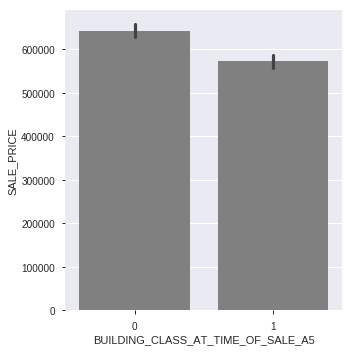

BUILDING_CLASS_AT_TIME_OF_SALE_A0


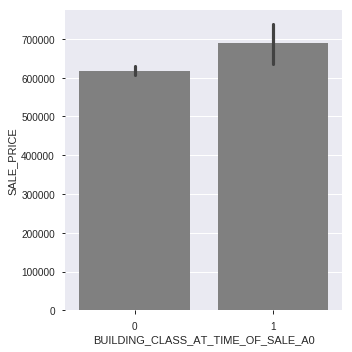

BUILDING_CLASS_AT_TIME_OF_SALE_A2


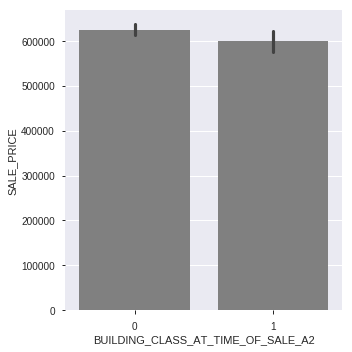

BUILDING_CLASS_AT_TIME_OF_SALE_A3


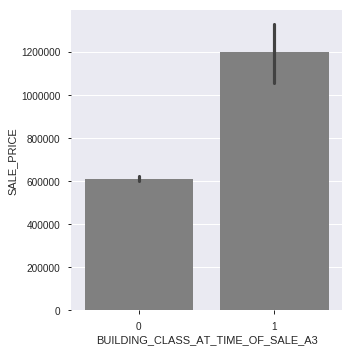

BUILDING_CLASS_AT_TIME_OF_SALE_A4


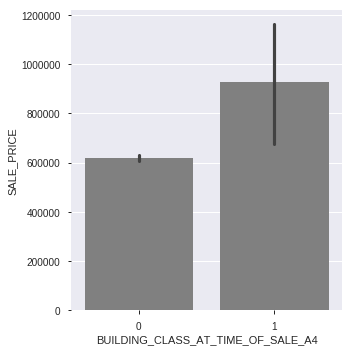

BUILDING_CLASS_AT_TIME_OF_SALE_A6


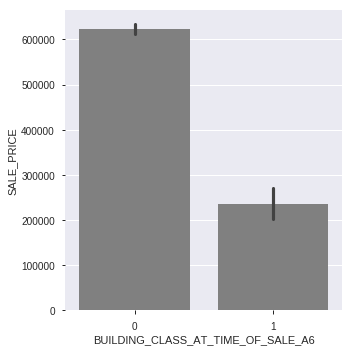

In [119]:
for col in train.columns.to_list():
  if (len(train[col].value_counts())==1):
    #any feature with only one value has no variance and doesn't inform us of anything additional. 
    train=train.drop(col, axis=1)
    continue
  if (len(train[col].value_counts())<11):
    print(col)
    sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
    plt.show()
  else:
    print(col, len(train[col].value_counts()),df[col].dtypes)

#these visualizations show that there are still some errors in the dataset
#single family units shouldn't have multiple residential units or comercial units
#garbage in garbage out. I'll have to clean up the data a bit more. 
#there is no time that there should be more or less than one total units. 
#land sq feet should be an int, also needed some cleanup 


In [14]:
train_subset=train.select_dtypes('number')
test_subset=test.select_dtypes('number')

['BOROUGH',
 'BLOCK',
 'LOT',
 'ZIP_CODE',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'YEAR_BUILT',
 'SALE_PRICE']

In [0]:
import numpy as np


In [57]:
from sklearn.feature_selection import SelectKBest, f_regression
feats=np.array(train_subset.columns.to_list()[:-1])
tar='SALE_PRICE'
#separate out the data
X=train_subset[feats]
y=train_subset[tar]
X_test=test_subset[feats]
y_test=test_subset[tar]

#initiate the selector
Kbest=SelectKBest(f_regression, k=3)

#fit on the training data 
selected=Kbest.fit_transform(X,y)
test_selected=Kbest.transform(X_test)

allCols=train_subset.columns
selectionMask=Kbest.get_support()

feats[selectionMask]

array(['ZIP_CODE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET'], dtype='<U17')

In [54]:
A = np.array([3,4,6,10,24,89,45,43,46,99,100])
A%3!=0

array([False,  True, False,  True, False,  True, False,  True,  True,
       False,  True])

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [80]:
for i in range(1,8):
  Kbesty=SelectKBest(score_func=f_regression, k=i)
  XtrSelect=Kbesty.fit_transform(X,y)
  XteSelct=Kbesty.transform(X_test)

  model=LinearRegression()

  model.fit(XtrSelect, y)
  y_pred= model.predict(XteSelct)
  mae= mean_absolute_error(y_test, y_pred)
  print(i, 'features')
  print(f'Test MAE ${mae:.2f}')



1 features
Test MAE $183818.40
2 features
Test MAE $179406.41
3 features
Test MAE $178474.74
4 features
Test MAE $158585.42
5 features
Test MAE $158199.53
6 features
Test MAE $158175.07
7 features
Test MAE $156960.82


In [81]:
train.describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2436,2436,2436,2436,2436
unique,175,10,2426,8,68
top,FLUSHING-NORTH,A1,104-18 187TH STREET,A1,2019-01-31 00:00:00
freq,75,919,2,919,75
first,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [82]:
train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    919
A5    779
A2    413
A9    193
A0     67
A3     38
A6     14
A4     13
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [0]:
import category_encoders as ce

In [87]:
encoder=ce.OneHotEncoder(use_cat_names=True)
encoding=encoder.fit_transform(train['BUILDING_CLASS_AT_TIME_OF_SALE'])
train=pd.concat([train, encoding], axis=1)

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6
44,3,OCEAN PARKWAY-NORTH,5495,801,A9,4832 BAY PARKWAY,11230.0,6800,1325.0,1930.0,A9,550000,2019-01-01,1,0,0,0,0,0,0,0
61,4,QUEENS VILLAGE,7918,72,A1,80-23 232ND STREET,11427.0,4000,2001.0,1940.0,A1,200000,2019-01-01,0,1,0,0,0,0,0,0
78,2,PELHAM PARKWAY SOUTH,4210,19,A1,1260 RHINELANDER AVE,10461.0,3500,2043.0,1925.0,A1,810000,2019-01-02,0,1,0,0,0,0,0,0
108,3,FLATBUSH-CENTRAL,5212,69,A1,469 E 25TH ST,11226.0,4000,2680.0,1899.0,A1,125000,2019-01-02,0,1,0,0,0,0,0,0
111,3,FLATBUSH-EAST,7930,121,A5,5521 WHITTY LANE,11203.0,1710,1872.0,1940.0,A5,620000,2019-01-02,0,0,1,0,0,0,0,0
120,3,MADISON,6806,72,A1,1747 EAST 23RD STREET,11229.0,4000,1932.0,1930.0,A1,1150000,2019-01-02,0,1,0,0,0,0,0,0
121,3,MIDWOOD,6761,42,A1,1582 EAST 15TH STREET,11230.0,2000,1722.0,1920.0,A1,836500,2019-01-02,0,1,0,0,0,0,0,0
132,4,BAYSIDE,7378,4,A1,201-08 50TH AVENUE,11364.0,3000,1396.0,1930.0,A1,955000,2019-01-02,0,1,0,0,0,0,0,0
137,4,ELMHURST,2882,16,A5,85-11 57 ROAD,11373.0,1800,1260.0,1935.0,A5,820000,2019-01-02,0,0,1,0,0,0,0,0
141,4,FLUSHING-NORTH,7407,50,A0,53-19 198TH STREET,11365.0,4000,1440.0,1945.0,A0,980000,2019-01-02,0,0,0,1,0,0,0,0


In [0]:
encoding=encoder.fit_transform(df['BUILDING_CLASS_AT_TIME_OF_SALE'])
df=pd.concat([df,encoding], axis=1)


In [0]:
train=df[df['SALE_DATE']<'2019-04'].select_dtypes('number')
test=df[df['SALE_DATE']>='2019-04'].select_dtypes('number')

In [0]:
cols=train.columns.to_list()
cols.remove('SALE_PRICE')


In [105]:
len(cols)

19

In [0]:
X=train[cols]
y=train[tar]
X_test2=test[cols]
y_test=test[tar]

In [107]:
for i in range(1, len(cols)+1): 
  selector=SelectKBest(score_func=f_regression, k=i)
  Xselect=selector.fit_transform(X,y)
  XtestSelect=selector.transform(X_test2)

  model=LinearRegression()
  model.fit(Xselect,y)
  y_pred=model.predict(XtestSelect)

  mae=mean_absolute_error(y_test, y_pred)
  print(f'{i} features \n Test MAE: ${mae:,.2f}')

1 features 
 Test MAE: $183,818.40
2 features 
 Test MAE: $179,406.41
3 features 
 Test MAE: $179,165.10
4 features 
 Test MAE: $178,145.70
5 features 
 Test MAE: $158,341.80
6 features 
 Test MAE: $158,410.96
7 features 
 Test MAE: $158,236.15
8 features 
 Test MAE: $158,258.35
9 features 
 Test MAE: $157,970.25
10 features 
 Test MAE: $157,936.73
11 features 
 Test MAE: $157,513.47
12 features 
 Test MAE: $157,475.08
13 features 
 Test MAE: $156,799.95
14 features 
 Test MAE: $156,769.88
15 features 
 Test MAE: $156,769.88
16 features 
 Test MAE: $156,769.88
17 features 
 Test MAE: $156,769.88
18 features 
 Test MAE: $156,769.88
19 features 
 Test MAE: $156,769.88


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equa

In [118]:
top10=df['NEIGHBORHOOD'].value_counts()[0:10].index.to_list()

df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

df.NEIGHBORHOOD.value_counts()

OTHER                       2369
FLUSHING-NORTH                95
ST. ALBANS                    91
SPRINGFIELD GARDENS           83
SO. JAMAICA-BAISLEY PARK      82
QUEENS VILLAGE                76
GREAT KILLS                   75
SOUTH OZONE PARK              69
BAYSIDE                       61
LAURELTON                     60
Name: NEIGHBORHOOD, dtype: int64